## 登入google帳戶以讀存取資料


In [ ]:
from google.colab import drive
drive.mount('/b05501039@g.ntu.edu.tw/')  #登入google帳戶以讀存取資料

## 設定Tensorflow版本與測試GPU

In [ ]:
%tensorflow_version 1.x  #切換tf版本(colab指令)
import tensorflow as tf
gpu_device_name = tf.test.gpu_device_name()
print(gpu_device_name) #確定device name
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
print(sess) #查看使用中的GPU

## Import Package

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy.io
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dropout, Dense
from keras.optimizers import RMSprop, Adam
from keras.layers import LSTM, Activation, CuDNNLSTM
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
from sklearn.externals import joblib  # save scaler
import time
from random import shuffle
import os
import eqsig.single


Using TensorFlow backend.


## Function

In [ ]:
def ScalingInput(train,test):
    train_flatten = np.reshape(train, [train.shape[0]*train.shape[1]*train.shape[2],1])  
    test_flatten = np.reshape(test, [test.shape[0]*test.shape[1]*test.shape[2],1]) 
    scaler_X = MinMaxScaler(feature_range=(-1, 1))  #標準化器
    scaler_X.fit(train_flatten)  #對應到要縮放的資料
    train_flatten_map = scaler_X.transform(train_flatten)  
    train_map = np.reshape(train_flatten_map, [train.shape[0], train.shape[1], train.shape[2]]) 
    test_flatten_map = scaler_X.transform(test_flatten)  
    test_map = np.reshape(test_flatten_map, [test.shape[0], test.shape[1], test.shape[2]]) 
    return train_map, test_map, scaler_X
 
def ScalingOutput(train,test):
    train_flatten = np.reshape(train, [train.shape[0]*train.shape[1] ,train.shape[2]])  
    test_flatten = np.reshape(test, [test.shape[0]*test.shape[1], test.shape[2]]) 
    scaler_y = MinMaxScaler(feature_range=(-1, 1))  #標準化器
    scaler_y.fit(train_flatten)  #對應到要縮放的資料
    train_flatten_map = scaler_y.transform(train_flatten)  
    train_map = np.reshape(train_flatten_map, [train.shape[0], train.shape[1], train.shape[2]]) 
    test_flatten_map = scaler_y.transform(test_flatten)  
    test_map = np.reshape(test_flatten_map, [test.shape[0], test.shape[1], test.shape[2]]) 
    return train_map, test_map, scaler_y

def prediction(X_scale_stack,y_scale_stack):
  pred = model.predict(X_scale_stack) 
  pred_flatten = np.reshape(pred, [pred.shape[0]*pred.shape[1], pred.shape[2]])  
  pred = scaler_y_Disp.inverse_transform(pred_flatten)  #將預測數值縮放回原大小 
  pred = np.reshape(pred, [y_scale_stack.shape[0], y_scale_stack.shape[1], y_scale_stack.shape[2]])  
  return pred

def MSE(Response_true,Response_pred):
  ErrorList=[]
  for i in range(Response_true.shape[0]):
      for k in range(Response_true.shape[2]):
        true_std = (Response_true[i,:,k] - Response_true[i,:,k].min()) / (Response_true[i,:,k].max() - Response_true[i,:,k].min())
        true_scaled = true_std * (1-(-1)) + (-1)
        pred_std = (Response_pred[i,:,k] - Response_true[i,:,k].min()) / (Response_true[i,:,k].max() - Response_true[i,:,k].min())
        pred_scaled = pred_std * (1-(-1)) + (-1)

        ErrorList.append( sum((pred_scaled- true_scaled)**2)/Response_true.shape[1] ) 
  Mse = np.array(ErrorList).reshape(Response_true.shape[0],Response_true.shape[2])
  return Mse

def PeakError(Response_true,Response_pred):
  ErrorList=[]
  for i in range(Response_true.shape[0]):
    for k in range(Response_true.shape[2]):
      Maxarg = np.argmax(Response_true[i,:,k])
      peak_error = (Response_pred[i,Maxarg,k] - Response_true[i,:,k].max())/Response_true[i,:,k].max()
      ErrorList.append(peak_error*100)
  Peak_Error = np.array(ErrorList).reshape(Response_true.shape[0],Response_true.shape[2])
  return Peak_Error

def Spectrum(GoodEarthquake, BadEarthquake,Goodstep,Badstep):
    #dt = 0.005  # time step of acceleration time series
    periods = np.linspace(0.2, 5, 100)  # compute the response for 100 periods between T=0.2s and 5.0s
    GoodSpectrum = []
    BadSpectrum = []
    for i in range(GoodEarthquake.shape[0]):
        Goodrecord = eqsig.AccSignal(GoodEarthquake[i]/1000 , Goodstep[i])
        Goodrecord.generate_response_spectrum(response_times=periods)
        goodspec = Goodrecord.s_a
        GoodSpectrum.append(Goodrecord.s_a)
    GoodSpectrum = np.array(GoodSpectrum)

    for i in range(BadEarthquake.shape[0]):
        Badrecord = eqsig.AccSignal(BadEarthquake[i]/1000 , Badstep[i])
        Badrecord.generate_response_spectrum(response_times=periods)
        BadSpectrum.append(Badrecord.s_a)
    BadSpectrum = np.array(BadSpectrum)
    return GoodSpectrum,BadSpectrum
    
def Generate_Spectrum(Earthquake,TimeStep):
    #dt = 0.005  # time step of acceleration time series
    periods = np.linspace(0.2, 5, 100)  # compute the response for 100 periods between T=0.2s and 5.0s
    Spectrum = []
    for i in range(Earthquake.shape[0]):
        record = eqsig.AccSignal(Earthquake[i]/1000 , TimeStep[i])
        record.generate_response_spectrum(response_times=periods,xi=0.02)
        goodspec = record.s_a
        Spectrum.append(record.s_a)
    Spectrum = np.array(Spectrum)
    return Spectrum


In [2]:
print('無基線修正總data:914')
print('有基線修正總data:718')
print('無基線修正總data:914, train:639, test:275')
print('有基線修正總data:718, train:502, test:216')
print('training set:1141, testing:491')


無基線修正總data:914
有基線修正總data:718
無基線修正總data:914, train:639, test:275
有基線修正總data:718, train:502, test:216
training set:1141, testing:491


## Prediction And Plot total Floors Response

In [3]:
#-------------------------------------------------------------------------------
# Load training data and validation data
dataDir = r'E:\\我的雲端硬碟\\AI center intern\\nonlinear_seismic_response_analysis\\August\\0.2g_Earthquake\\' 
resultDir = r'E:\\我的雲端硬碟\\AI center intern\\nonlinear_seismic_response_analysis\\August\\0.2g_Earthquake\\Disp\\0.2gDisp8\\model1\\'  
mat_data = scipy.io.loadmat(dataDir+'NewData_Disp.mat')
mat_analysis = scipy.io.loadmat(dataDir+'Disp02g_Analysis.mat')

# original data
X_train_stack = mat_data['X_train_stack']
y_Disp_train_stack = mat_data['y_Disp_train_stack']
X_test_stack = mat_data['X_test_stack']
y_Disp_test_stack = mat_data['y_Disp_test_stack']
X_train_scale_stack, X_test_scale_stack, scaler_X = ScalingInput(X_train_stack,X_test_stack)
y_Disp_train_scale_stack, y_Disp_test_scale_stack, scaler_y_Disp = ScalingOutput(y_Disp_train_stack,y_Disp_test_stack)

# 解壓縮地震
X_train_earthquake = X_train_stack.reshape(X_train_stack.shape[0],X_train_stack.shape[1]*X_train_stack.shape[2])
X_test_earthquake = X_test_stack.reshape(X_test_stack.shape[0],X_test_stack.shape[1]*X_test_stack.shape[2])

# earthquake
name_train = mat_data['name_train']
name_test = mat_data['name_test']
steps_train = mat_data['step_train']
steps_test = mat_data['step_test']
steps_train = np.reshape(steps_train,(steps_train.shape[-1]))
steps_test = np.reshape(steps_test,(steps_test.shape[-1]))

'''
# 分類表現好壞資料
TrainGoodInd = mat_analysis['TrainGoodInd'][8][0][0]
TrainBadInd = mat_analysis['TrainBadInd'][8][0][0]
TestGoodInd = mat_analysis['TestGoodInd'][8][0][0]
TestBadInd = mat_analysis['TestBadInd'][8][0][0]
'''

#-------------------------------------------------------------------------------
# Load the best model
model = load_model(resultDir+'best_model.h5')
# Predict Training data and Testing data  
y_Disp_train_stack_pred = prediction(X_train_scale_stack,y_Disp_train_scale_stack)
y_Disp_test_stack_pred = prediction(X_test_scale_stack, y_Disp_test_scale_stack)

"\n#-------------------------------------------------------------------------------\n# Load the best model\nmodel = load_model(resultDir+'best_model.h5')\n#scaler_X = joblib.load(dataDir+'scaler_X.save')\n#scaler_y = joblib.load(dataDir+'scaler_y_Acc.save')\n\ndef prediction(X_scale_stack,y_scale_stack):\n  pred = model.predict(X_scale_stack) \n  pred_flatten = np.reshape(pred, [pred.shape[0]*pred.shape[1], pred.shape[2]])  \n  pred = scaler_y_Disp.inverse_transform(pred_flatten)  #將預測數值縮放回原大小 \n  pred = np.reshape(pred, [y_scale_stack.shape[0], y_scale_stack.shape[1], y_scale_stack.shape[2]])  \n  return pred\n\n# Predict Training data and Testing data  \ny_Disp_train_stack_pred = prediction(X_train_scale_stack,y_Disp_train_scale_stack)\ny_Disp_test_stack_pred = prediction(X_test_scale_stack, y_Disp_test_scale_stack)"

## Normalized MSE

In [4]:
Train_MSE = MSE(y_Disp_train_stack,y_Disp_train_stack_pred)
Test_MSE = MSE(y_Disp_test_stack,y_Disp_test_stack_pred)
Train_PeakError = PeakError(y_Disp_train_stack,y_Disp_train_stack_pred)
Test_PeakError = PeakError(y_Disp_test_stack,y_Disp_test_stack_pred)

## Plot Normalized MSE distribution

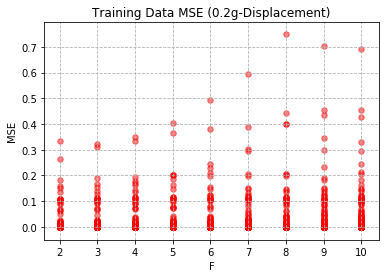

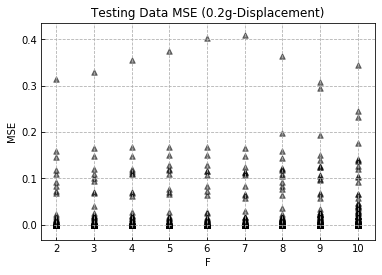

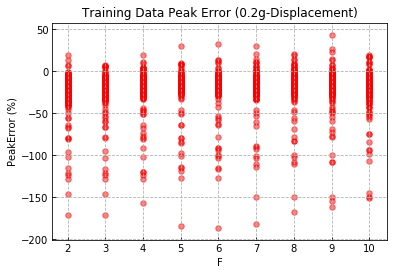

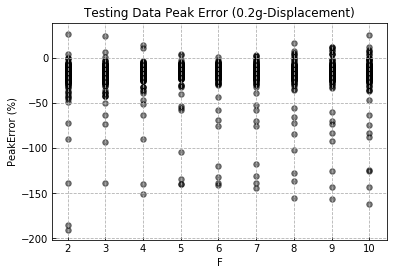

In [5]:
## Normalized MSE
plt.figure()
for i in range(1,10):
  plt.scatter((np.ones(Train_MSE.shape[0])+i).astype(np.int8),Train_MSE[:,i-1],s=30,c='red',marker='o',alpha=0.5,)
plt.title('Training Data MSE (0.2g-Displacement)')
plt.xlabel('F')
plt.ylabel('MSE')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.grid(linestyle='--')

plt.figure()
for i in range(1,10):
  plt.scatter((np.ones(Test_MSE.shape[0])+i).astype(np.int8),Test_MSE[:,i-1],s=30,c='black',marker='^',alpha=0.5,)
plt.title('Testing Data MSE (0.2g-Displacement)')
plt.xlabel('F')
plt.ylabel('MSE')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.grid(linestyle='--')

## Peak Error
plt.figure()
for i in range(1,10):
  plt.scatter((np.ones(Train_PeakError.shape[0])+i).astype(np.int8),Train_PeakError[:,i-1],s=30,c='red',marker='o',alpha=0.5,)
plt.title('Training Data Peak Error (0.2g-Displacement)')
plt.xlabel('F')
plt.ylabel('PeakError (%)')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.grid(linestyle='--')

plt.figure()
for i in range(1,10):
  plt.scatter((np.ones(Test_PeakError.shape[0])+i).astype(np.int8),Test_PeakError[:,i-1],s=30,c='black',marker='o',alpha=0.5,)
plt.title('Testing Data Peak Error (0.2g-Displacement)')
plt.xlabel('F')
plt.ylabel('PeakError (%)')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.grid(linestyle='--')





## Plot Normalized MSE distribution


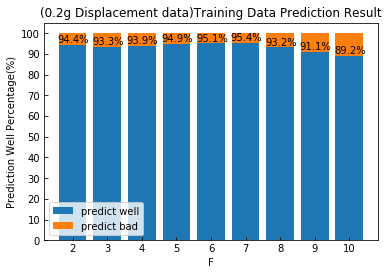

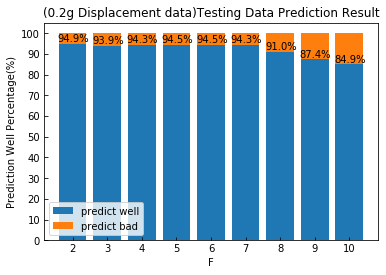

In [6]:
PerformanceIndex = 0.005
MSEList = [[Train_MSE,'(0.2g Displacement data)Training'],[Test_MSE,'(0.2g Displacement data)Testing']]
TrainGoodInd = []
TrainBadInd = []
TestGoodInd = []
TestBadInd = []
temp=0 
for sample in MSEList:  
  GoodList = []
  BadList = []
  for i in range(9):
    StoryMSE = sample[0][:,i]
    GoodData = StoryMSE[StoryMSE<=PerformanceIndex]
    Goodindex = np.where(StoryMSE<=PerformanceIndex)
    Badindex = np.where(StoryMSE>PerformanceIndex)
    if temp == 0:
        TrainGoodInd.append(Goodindex)
        TrainBadInd.append(Badindex)
    else:
        TestGoodInd.append(Goodindex)
        TestBadInd.append(Badindex)

    GoodList.append(GoodData.shape[0]/StoryMSE.shape[0]*100)
    BadList.append(100 - GoodData.shape[0] / StoryMSE.shape[0]*100)
  temp+=1

  x = np.arange(9)+2
  plt.figure()
  plt.bar(x, GoodList, label='predict well')
  plt.bar(x, BadList, bottom=GoodList,label='predict bad')
  for xy in zip(x, GoodList):
    plt.annotate("%.1f" %xy[1]+'%', xy=xy, xytext=(-15, 2), textcoords='offset points')
  plt.title(sample[1]+' Data Prediction Result')
  plt.xlabel('F')
  plt.ylabel('Prediction Well Percentage(%)')
  plt.xticks(x)
  plt.yticks(np.arange(0, 105, 10))
  plt.legend(loc = 'lower left') 
  plt.show()



## Base Line Correction
分出經過基線修正之地震資料，並且繪製反應譜

In [4]:
## 整合基線修正資料
BC_earthquake = np.concatenate((X_train_earthquake[639:],X_test_earthquake[275:]))
name_BC = np.concatenate((name_train[639:],name_test[275:]))
steps_BC = np.concatenate((steps_train[639:],steps_test[275:]))
X_stack_BC = np.concatenate((X_train_stack[639:],X_test_stack[275:]))
y_Disp_stack_BC = np.concatenate((y_Disp_train_stack[639:],y_Disp_test_stack[275:]))

BC_Spectrum = Generate_Spectrum(BC_earthquake,steps_BC)
scipy.io.savemat(dataDir+'NewData_Disp_BC.mat',
                 { 'BC_Spectrum': BC_Spectrum,'X_stack_BC':X_stack_BC,'y_Disp_stack_BC':y_Disp_stack_BC,
                 'name_BC':name_BC,'steps_BC':steps_BC})

## Classify Data
將預測表現表現好與差的資料分開

In [6]:
TrainGoodEarthquake = X_train_earthquake[TrainGoodInd]
TrainBadEarthquake = X_train_earthquake[TrainBadInd]
TestGoodEarthquake = X_test_earthquake[TestGoodInd]
TestBadEarthquake = X_test_earthquake[TestBadInd]

steps_train_Good = steps_train[TrainGoodInd]
steps_train_Bad = steps_train[TrainBadInd]
steps_test_Good = steps_test[TestGoodInd]
steps_test_Bad = steps_test[TestBadInd]

Good_name_train = name_train[TrainGoodInd]
Bad_name_train = name_train[TrainBadInd]
Good_name_test = name_test[TestGoodInd]
Bad_name_test = name_test[TestBadInd]

TrainGoodSpectrum,TrainBadSpectrum = Spectrum(TrainGoodEarthquake,TrainBadEarthquake,steps_train_Good,steps_train_Bad)
TestGoodSpectrum,TestBadSpectrum = Spectrum(TestGoodEarthquake,TestBadEarthquake,steps_test_Good,steps_test_Bad)
scipy.io.savemat(dataDir+'Disp02g_Analysis.mat',
                 { 'TrainGoodSpectrum': TrainGoodSpectrum,'TrainBadSpectrum':TrainBadSpectrum,'TestGoodSpectrum':TestGoodSpectrum,'TestBadSpectrum':TestBadSpectrum,
                 'Good_name_train':Good_name_train,'Bad_name_train':Bad_name_train,'Good_name_test':Good_name_test,'Bad_name_test':Bad_name_test,
                 'steps_train_Good':steps_train_Good,'steps_train_Bad':steps_train_Bad,'steps_test_Good':steps_test_Good,'steps_test_Bad':steps_test_Bad,
                 'TrainGoodInd':TrainGoodInd,'TrainBadInd':TrainBadInd,'TestGoodInd':TestGoodInd,'TestBadInd':TestBadInd})


## 畫平均反應譜
將兩類資料化反應譜取平均值，觀察兩類地震資料特性

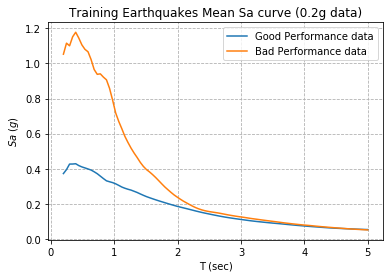

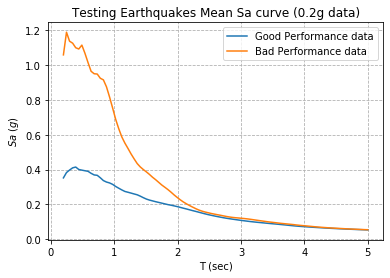

In [8]:
MeanGoodTrain = sum(TrainGoodSpectrum)/len(TrainGoodSpectrum)
MeanBadTrain = sum(TrainBadSpectrum)/len(TrainBadSpectrum)
MeanGoodTest = sum(TestGoodSpectrum)/len(TestGoodSpectrum)
MeanBadTest = sum(TestBadSpectrum)/len(TestBadSpectrum)

plt.figure()
plt.plot(np.linspace(0.2, 5, 100),MeanGoodTrain/9.8,label='Good Performance data')
plt.plot(np.linspace(0.2, 5, 100),MeanBadTrain/9.8,label='Bad Performance data')
plt.title('Training Earthquakes Mean Sa curve (0.2g data)')
plt.xlabel('T (sec)')
plt.ylabel('$Sa\ (g)$')
plt.grid(linestyle='--')
plt.legend(loc = 'upper right') 


plt.figure()
plt.plot(np.linspace(0.2, 5, 100),MeanGoodTest/9.8,label='Good Performance data')
plt.plot(np.linspace(0.2, 5, 100),MeanBadTest/9.8,label='Bad Performance data')
plt.title('Testing Earthquakes Mean Sa curve (0.2g data)')
plt.xlabel('T (sec)')
plt.ylabel('$Sa\ (g)$')
plt.grid(linestyle='--')
plt.legend(loc = 'upper right') 